In [50]:
pip install pandas numpy scikit-learn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [51]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [52]:
# Load the dataset
df = pd.read_csv("posture_data.csv")

# Encode labels (Good -> 1, Bad -> 0)
le = LabelEncoder()
df['posture'] = le.fit_transform(df['posture'])

# Define input features and target
features = ['angleX', 'angleY', 'angleZ', 'fsrLeft', 'fsrRight', 'fsrDiff']
X = df[features]
y = df['posture']

In [53]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [ ]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

✅ Accuracy: 0.9966666666666667

✅ Classification Report:
              precision    recall  f1-score   support

         Bad       1.00      1.00      1.00       300
        Good       1.00      1.00      1.00       300

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



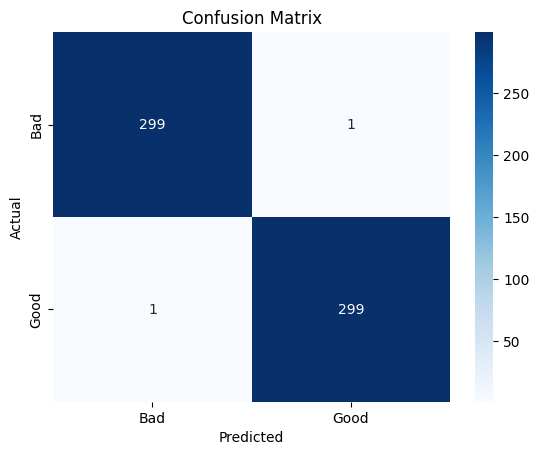

In [ ]:
y_pred = rf.predict(X_test)

# Accuracy
print("✅ Accuracy:", accuracy_score(y_test, y_pred))

# Classification Report
print("\n✅ Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Bad', 'Good']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Bad', 'Good'], yticklabels=['Bad', 'Good'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

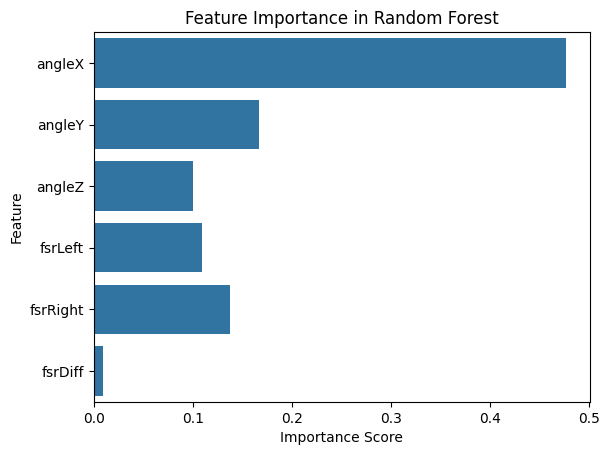

In [ ]:
importances = rf.feature_importances_
sns.barplot(x=importances, y=features)
plt.title("Feature Importance in Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

In [ ]:
from joblib import dump
dump(rf, 'random_forest_model.joblib')
dump(scaler, 'scaler.joblib')


['scaler.joblib']

In [ ]:
pip install pyserial

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
try:
    ser.close()
    print("✅ Serial port closed.")
except:
    print("⚠️ Serial port was already closed or not initialized.")


✅ Serial port closed.


In [ ]:
import serial
ser = serial.Serial('COM4', 9600)


In [ ]:
if ser.is_open:
    ser.close()


In [ ]:
try:
    ser.close()
    print("✅ Serial port closed.")
except:
    print("⚠️ Serial port was already closed or not initialized.")


✅ Serial port closed.


In [55]:
if ser.is_open:
    ser.close()


In [16]:


import serial
import csv
import time

# Serial port setup
try:
    ser = serial.Serial('COM4', 9600, timeout=1)
    time.sleep(2)  # Wait for serial connection to initialize
except Exception as e:
    print(f"Error opening serial port: {e}")
    exit(1)

# Constants
MIN_FSR_VALUE = 10        # Threshold for weight sensing on FSRs
MOTION_THRESHOLD = 2.0    # Threshold for detecting motion/shaking on MPU

# Variables to track previous MPU angles for comparison
prevX, prevY, prevZ = None, None, None

# Open CSV files for logging
fsr_file = open("fsr_only_log.csv", 'w', newline='')
mpu_file = open("mpu_only_log.csv", 'w', newline='')

fsr_writer = csv.writer(fsr_file)
mpu_writer = csv.writer(mpu_file)

fsr_writer.writerow(['fsrLeft', 'fsrRight', 'fsrDiff', 'posture'])
mpu_writer.writerow(['angleX', 'angleY', 'angleZ', 'posture'])

print("📡 Monitoring posture using MPU and FSR together... Press Ctrl+C to stop.")

try:
    while True:
        try:
            line = ser.readline().decode('utf-8').strip()
            if not line:
                continue

            # Example line format expected:
            # angleX,angleY,angleZ,fsrLeft,fsrRight,fsrDiff
            # e.g. -164.89,-74.49,-0.6,15,20,5

            # Skip headers or invalid lines
            if "angleX" in line or not all(c.isdigit() or c in "-.,+" for c in line.replace(' ','')):
                continue

            parts = line.split(',')
            if len(parts) < 6:
                continue

            # Parse MPU angles
            angleX = float(parts[0])
            angleY = float(parts[1])
            angleZ = float(parts[2])

            # Parse FSR readings
            fsrLeft = float(parts[3])
            fsrRight = float(parts[4])
            fsrDiff = float(parts[5])

            # === FSR-based posture ===
            if fsrLeft > MIN_FSR_VALUE and fsrRight > MIN_FSR_VALUE:
                fsr_posture = 'Good'
            else:
                fsr_posture = 'Bad'
            fsr_writer.writerow([fsrLeft, fsrRight, fsrDiff, fsr_posture])

            # === MPU-based posture ===
            if prevX is None:
                mpu_posture = 'Good'
            else:
                diffX = abs(angleX - prevX)
                diffY = abs(angleY - prevY)
                diffZ = abs(angleZ - prevZ)

                if diffX > MOTION_THRESHOLD or diffY > MOTION_THRESHOLD or diffZ > MOTION_THRESHOLD:
                    mpu_posture = 'Bad'
                else:
                    mpu_posture = 'Good'

            mpu_writer.writerow([angleX, angleY, angleZ, mpu_posture])
            prevX, prevY, prevZ = angleX, angleY, angleZ

            # Print both results
            print(f"🧭 Angles: X={angleX}, Y={angleY}, Z={angleZ} | 🪑 MPU Posture: {mpu_posture}")
            print(f"📊 FSRs: Left={fsrLeft}, Right={fsrRight}, Diff={fsrDiff} | 🪑 FSR Posture: {fsr_posture}")
            print("----")

        except Exception as e:
            print(f"⚠️ Error processing line: {line} | {e}")

except KeyboardInterrupt:
    print("\n🛑 Monitoring stopped by user.")

finally:
    ser.close()
    fsr_file.close()
    mpu_file.close()
    print("Serial port and files closed safely.")


📡 Monitoring posture using MPU and FSR together... Press Ctrl+C to stop.
🧭 Angles: X=-171.4, Y=-31.04, Z=-1.12 | 🪑 MPU Posture: Good
📊 FSRs: Left=0.0, Right=0.0, Diff=0.0 | 🪑 FSR Posture: Bad
----
🧭 Angles: X=-167.21, Y=-29.6, Z=-0.39 | 🪑 MPU Posture: Bad
📊 FSRs: Left=0.0, Right=0.0, Diff=0.0 | 🪑 FSR Posture: Bad
----
🧭 Angles: X=-165.34, Y=-42.59, Z=-0.5 | 🪑 MPU Posture: Bad
📊 FSRs: Left=0.0, Right=0.0, Diff=0.0 | 🪑 FSR Posture: Bad
----
🧭 Angles: X=-162.09, Y=-37.29, Z=0.86 | 🪑 MPU Posture: Bad
📊 FSRs: Left=0.0, Right=0.0, Diff=0.0 | 🪑 FSR Posture: Bad
----
🧭 Angles: X=-158.58, Y=-32.89, Z=0.9 | 🪑 MPU Posture: Bad
📊 FSRs: Left=966.0, Right=927.0, Diff=39.0 | 🪑 FSR Posture: Good
----
🧭 Angles: X=-153.74, Y=-29.51, Z=0.94 | 🪑 MPU Posture: Bad
📊 FSRs: Left=989.0, Right=978.0, Diff=11.0 | 🪑 FSR Posture: Good
----
🧭 Angles: X=-150.7, Y=-29.38, Z=1.03 | 🪑 MPU Posture: Bad
📊 FSRs: Left=982.0, Right=947.0, Diff=35.0 | 🪑 FSR Posture: Good
----
🧭 Angles: X=-148.12, Y=-30.12, Z=1.05 | 🪑 MPU Pos